# k-Anonymity

In this notebook, we'll explore data anonymization, in particular "k-anonymity" [1]. We will implement a simple algorithm [2] to produce a k-anonymous dataset.

For more reading on the topic, please see: 

- [k-Anonymity: A Model For Protecting Privacy. Latanya Sweeney](https://epic.org/privacy/reidentification/Sweeney_Article.pdf)
- [Mondrian - Multidimensional k-Anonymity](https://www.utdallas.edu/~muratk/courses/privacy08f_files/MultiDim.pdf)

## Introduction


k-anonymity protects the privacy of individual persons by pooling their attributes into groups of at least $k$ people. The method is based on the assumption that we have a dataset that contains $N$ entries. Each entry consists of a list of $D$ attributes $X_i$ ($i \in [0,D]$) that contain (non-sensitive) information about a person, such as age, gender, zip code of residence, etc. These attributes are called "quasi-identifiers", as combining several of them into a "super-identifier" can often uniquely identify a person even in large datasets (e.g. the combination of gender, age and zip code might be so specific that only a single person in a dataset has a given combination). In addition, the model assumes that the dataset contains a single sensitive attribute that contains e.g. information about a person's income and that we want to protect. The method can also be generalized to datasets with more than one sensitive attribute or datasets where there's no clear distinction between quasi-identifiers and sensitive attributes. For this case study we will look at the simple case though.

Now, k-anonymity demands that we group individual rows/persons of our dataset into group of at least $k$ rows/persons and replace the quasi-identifier attributes of these rows with aggregate quantities, such that it is no longer possible to read the individual values. This protects people by ensuring that an adversary who knows all values of a person's quasi-identifier attributes can only find out which group a person might belong to but not know if the person is really in the dataset.

A large problem of this approach is that it might happen that all people in a k-anonymous group possess the same value of the sensitive attribute. An adversary who knows that a person is in that k-anonymous group can then still learn the value of the sensitive attribute of that person with absolute certainty. This problem can be fixed by using an extension of k-anonymity called "l-diversity": l-diversity ensures that each k-anonymous group contains at least l different values of the sensitive attribute. Therefore, evne if an adversary can identify the group of a person he/she still would not be able to find out the value of that person's sensitive attribute with certainty. 

However, even when using l-diversity an adversary could still learn some information about a person's sensitive attribute using probabilistic reasoning: If, for example, 4 out of 5 people in a 5-anonymous group possess a given value of the sensitive attribute, an attacker can reason that a given person who he/she knows is part of the group will -with high probability- possess that value. Again, this problem can be fixed by extending k-anonymity using a so-called "t-closeness" criterion: t-closeness demands that the statistical distribution of the sensitive attribute values in each k-anonymous group is "close" to the overall distribution of that attribute in the entire dataset. Typically, the closeness can be measured using e.g. the Kullback-Leibler (KL) divergence. An adversary could then only learn a limited amount of information from comparing the distribution of the values in the group to the distribution in the entire dataset.

Of course, k-anonymity, l-diversity and t-closeness all limit the amount of information that a legitimate user can learn from the data as well, so typically we need to balance the degree of privacy against the utility of the resulting data.

## Implementing k-anonymity

Turning a dataset into a k-anonymous (and possibly l-diverse or t-close) dataset is a complex problem, and finding the optimal partition into k-anonymous groups is an NP-hard problem. Fortunately, several practical algorithms exists that often produce "good enough" results by employing greedy search techniques.

In this tutorial we will explore the so-called "Mondrian" algorithm (see link above), which uses a greedy search algorithm to parition the original data into smaller and smaller groups (if we plot the resulting partition boundaries in 2D they resemble the pictures by Piet Mondrian, hence the name).

The algorithm assumes that we have converted all attributes into numerical or categorical values and that we're able to measure the "span" of a given data attribute $X_i$ (we'll explain that in more detail later).

### Partitioning

The algorithm proceeds then as follows to partition the data into k-anonymous gorups:

1. Initialize the finished set of partitions to an empty set $P_{finished} = \{\}$.
2. Initialize the working set of paritions to a set containing a partition with the entire dataset $P_{working} = \{\{1, 2,\dots ,N\}\}$.
4. While there are partitions in the working set, pop one partition from it and
  * Calculate the relative spans of all columns in the partition.
  * Sort the resulting columns by their span (in descending order) and iterate over them. For each column,
      * Try to split the partition along that column using the median of the column values as the split point.
      * Check if the resulting partitions are valid according to our k-anonymity (and possibly additional) criteria.
      * If yes, add the two new partitions to the working set and break out of the loop.
  * If no column produced a valid split, add the original partition to the set of finished partitions.
5. Return the finished set of partitions

### Data Aggregation

After obtaining the partitions we still need to aggregate the values of the quasi identifiers and the sensitive attributes in each k-anonymous group. For this, we can e.g. replace numerical attributes with their range (e.g. "age: 24-28") and categorical attributes with their union (e.g. "employment-group: [self-employed, employee, worker]"), though other aggregations are possible. Methods like [Anatomy](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.156.9150&rep=rep1&type=pdf) even preserve the micro-data in each group, which increases re-identification risk though.

## Usage of the Anonymized Data

We can then use the anonymized data for privacy-preserving machine learning, e.g. using scikit-learn. If we have time at the end of this part we'll cover this as well. With the dataset generation method discussed here you can use the resulting datasets just as you would use a normal dataset though, so there's really nothing special about the anonymized data here.

Let's get started with the anonymization!

In [1]:
# we use Pandas to work with the data as it makes working with categorical data very easy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc

%matplotlib inline
plt.style.use("classic")
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
rc('text', usetex=True)
# plt.rc("text", usetex=True)
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white"})
plt.rcParams["figure.autolayout"] = True
# pd.set_option('max_columns', None)

In [2]:
# this is a list of the column names in our dataset (as the file doesn't contain any headers)
# names = (
#     'age',
#     'workclass', #Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
#     'fnlwgt', # "weight" of that person in the dataset (i.e. how many people does that person represent) -> https://www.kansascityfed.org/research/datamuseum/cps/coreinfo/keyconcepts/weights
#     'education',
#     'education-num',
#     'marital-status',
#     'occupation',
#     'relationship',
#     'race',
#     'sex',
#     'capital-gain',
#     'capital-loss',
#     'hours-per-week',
#     'native-country',
#     'income',
# )

# some fields are categorical and will require special treatment
# categorical = set((
#     'workclass',
#     'education',
#     'marital-status',
#     'occupation',
#     'relationship',
#     'sex',
#     'native-country',
#     'race',
#     'income',
# ))
df = pd.read_csv("mimic3d.csv", 
                 sep=",", 
                 # header=None, 
                 # names=names, 
                 index_col="hadm_id", 
                 engine='python');# We load the data using Pandas
df.drop(['AdmitDiagnosis','AdmitProcedure','LOSdays'],axis=1,inplace=True)
names = df.columns.to_list()

df["LOSgroupNum"]=df["LOSgroupNum"].apply(lambda x: str(x))
categorical = [col for col in df.columns if df[col].dtype=="object"]
numerical = [col for col in df.columns if df[col].dtype!="object"]

In [3]:
df.head()


,gender,age,admit_type,admit_location,insurance,religion,marital_status,ethnicity,NumCallouts,NumDiagnosis,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
hadm_id,,,,,,,,,,,,,,,,,,,,,
100001,F,35,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,PROTESTANT QUAKER,DIVORCED,WHITE,0.16,2.59,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
100003,M,59,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NOT SPECIFIED,SINGLE,WHITE,0.25,2.23,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
100006,F,48,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,0.00,0.75,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
100007,F,73,EMERGENCY,EMERGENCY ROOM ADMIT,Private,JEWISH,MARRIED,WHITE,0.41,0.69,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
100009,M,60,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,CATHOLIC,MARRIED,WHITE,0.00,3.69,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1


In [4]:
for name in categorical:
    df[name] = df[name].astype('category')

df.drop(columns=["marital_status"], inplace=True)
categorical.remove("marital_status")
names.remove("marital_status")

# df["AdmitDiagnosis"] = df["AdmitDiagnosis"].cat.add_categories("unknown")
df["religion"] = df["religion"].cat.add_categories("unknown")
# df["AdmitDiagnosis"].fillna("unknown", inplace=True)
df["religion"].fillna("unknown", inplace=True)

In [5]:
print(categorical)
print(names)
# print(df["gender"].dtype)
# print(df.isnull().sum())

['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 'ethnicity', 'LOSgroupNum']
['gender', 'age', 'admit_type', 'admit_location', 'insurance', 'religion', 'ethnicity', 'NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum']


**Implement a function that returns the spans (max-min for numerical columns, number of different values for categorical columns) of all columns for a partition of a dataframe.** 

In [6]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            # print("Column:",column)
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [7]:
full_spans = get_spans(df, df.index)
full_spans

{'gender': 2,
 'age': 89,
 'admit_type': 4,
 'admit_location': 9,
 'insurance': 5,
 'religion': 21,
 'ethnicity': 41,
 'NumCallouts': 4.76,
 'NumDiagnosis': 450.0,
 'NumProcs': 275.0,
 'NumCPTevents': 225.0,
 'NumInput': 6825.0,
 'NumLabs': 5175.0,
 'NumMicroLabs': 375.0,
 'NumNotes': 7500.0,
 'NumOutput': 375.0,
 'NumRx': 750.0,
 'NumProcEvents': 100.0,
 'NumTransfers': 125.0,
 'NumChartEvents': 49325.0,
 'ExpiredHospital': 1,
 'TotalNumInteract': 68600.0,
 'LOSgroupNum': 4}

**Implement a `split` function that takes a dataframe, partition and column and returns two partitions that split the given partition such that all rows with values of the column `column` below the median are in one partition and all rows with values above or equal to the median are in the other.**

In [8]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

Now that we have all helper functions in place, we can implement the partition algorithm discussed above:

**Implement the partitioning algorithm discussed above, using a k-anonymous criterion for the partitions you create.**

In [9]:
def is_k_anonymous(df, partition, sensitive_column, k=750):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

Now let's try this on our dataset! To keep things simple, we will at first select only two columns from the dataset that we apply the partitioning to. This makes it easier to check/visualize the result and speed up the execution (the naive algorithm can take several minutes when running on the entire dataset) 

In [10]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
sensitive_column = 'LOSgroupNum'
feature_columns = [col for col in names if col!=sensitive_column]
finished_partitions = partition_dataset(df, 
                                        feature_columns, 
                                        sensitive_column, 
                                        full_spans, 
                                        is_k_anonymous)

In [11]:
# we get the number of partitions that were created
print(len(finished_partitions))

63


Let's visualize the created partitions! To do that, we will write functions to get the rectangular bounds of a partition along two columns. We can then plot these rects to see how our partitioning function divides the dataset. If we perform the partition only along the two columns selected for plotting then the resulting rects should not overlap and cover the entire dataset.

In [12]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
#         except Exception as e:
#             print(e)
#             print(column)
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [13]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = "NumTransfers", "NumCallouts"
rects = get_partition_rects(df, 
                            finished_partitions, 
                            column_x, 
                            column_y, 
                            indexes, 
                            offsets=[0.0, 0.0])

In [14]:
# let's see how our rects look like
print(rects[:10])

[((0.0, 0.0), (125.0, 0.25)), ((0.0, 0.0), (100.0, 1.72)), ((0.0, 0.0), (100.0, 2.0)), ((0.0, 0.0), (0.97, 0.37)), ((0.0, 0.0), (0.97, 0.38)), ((0.97, 0.0), (1.69, 0.57)), ((1.69, 0.0), (125.0, 0.73)), ((0.0, 0.0), (0.61, 0.87)), ((0.0, 0.0), (0.61, 0.47)), ((0.61, 0.0), (0.96, 0.76))]


In [15]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),
                                       xr-xl,
                                       yr-yl,
                                       linewidth=4,
                                       edgecolor=edgecolor,
                                       facecolor=facecolor, 
                                       alpha=0.7))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x, fontsize = 80)
    ax.set_ylabel(column_y, fontsize = 80)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 60)

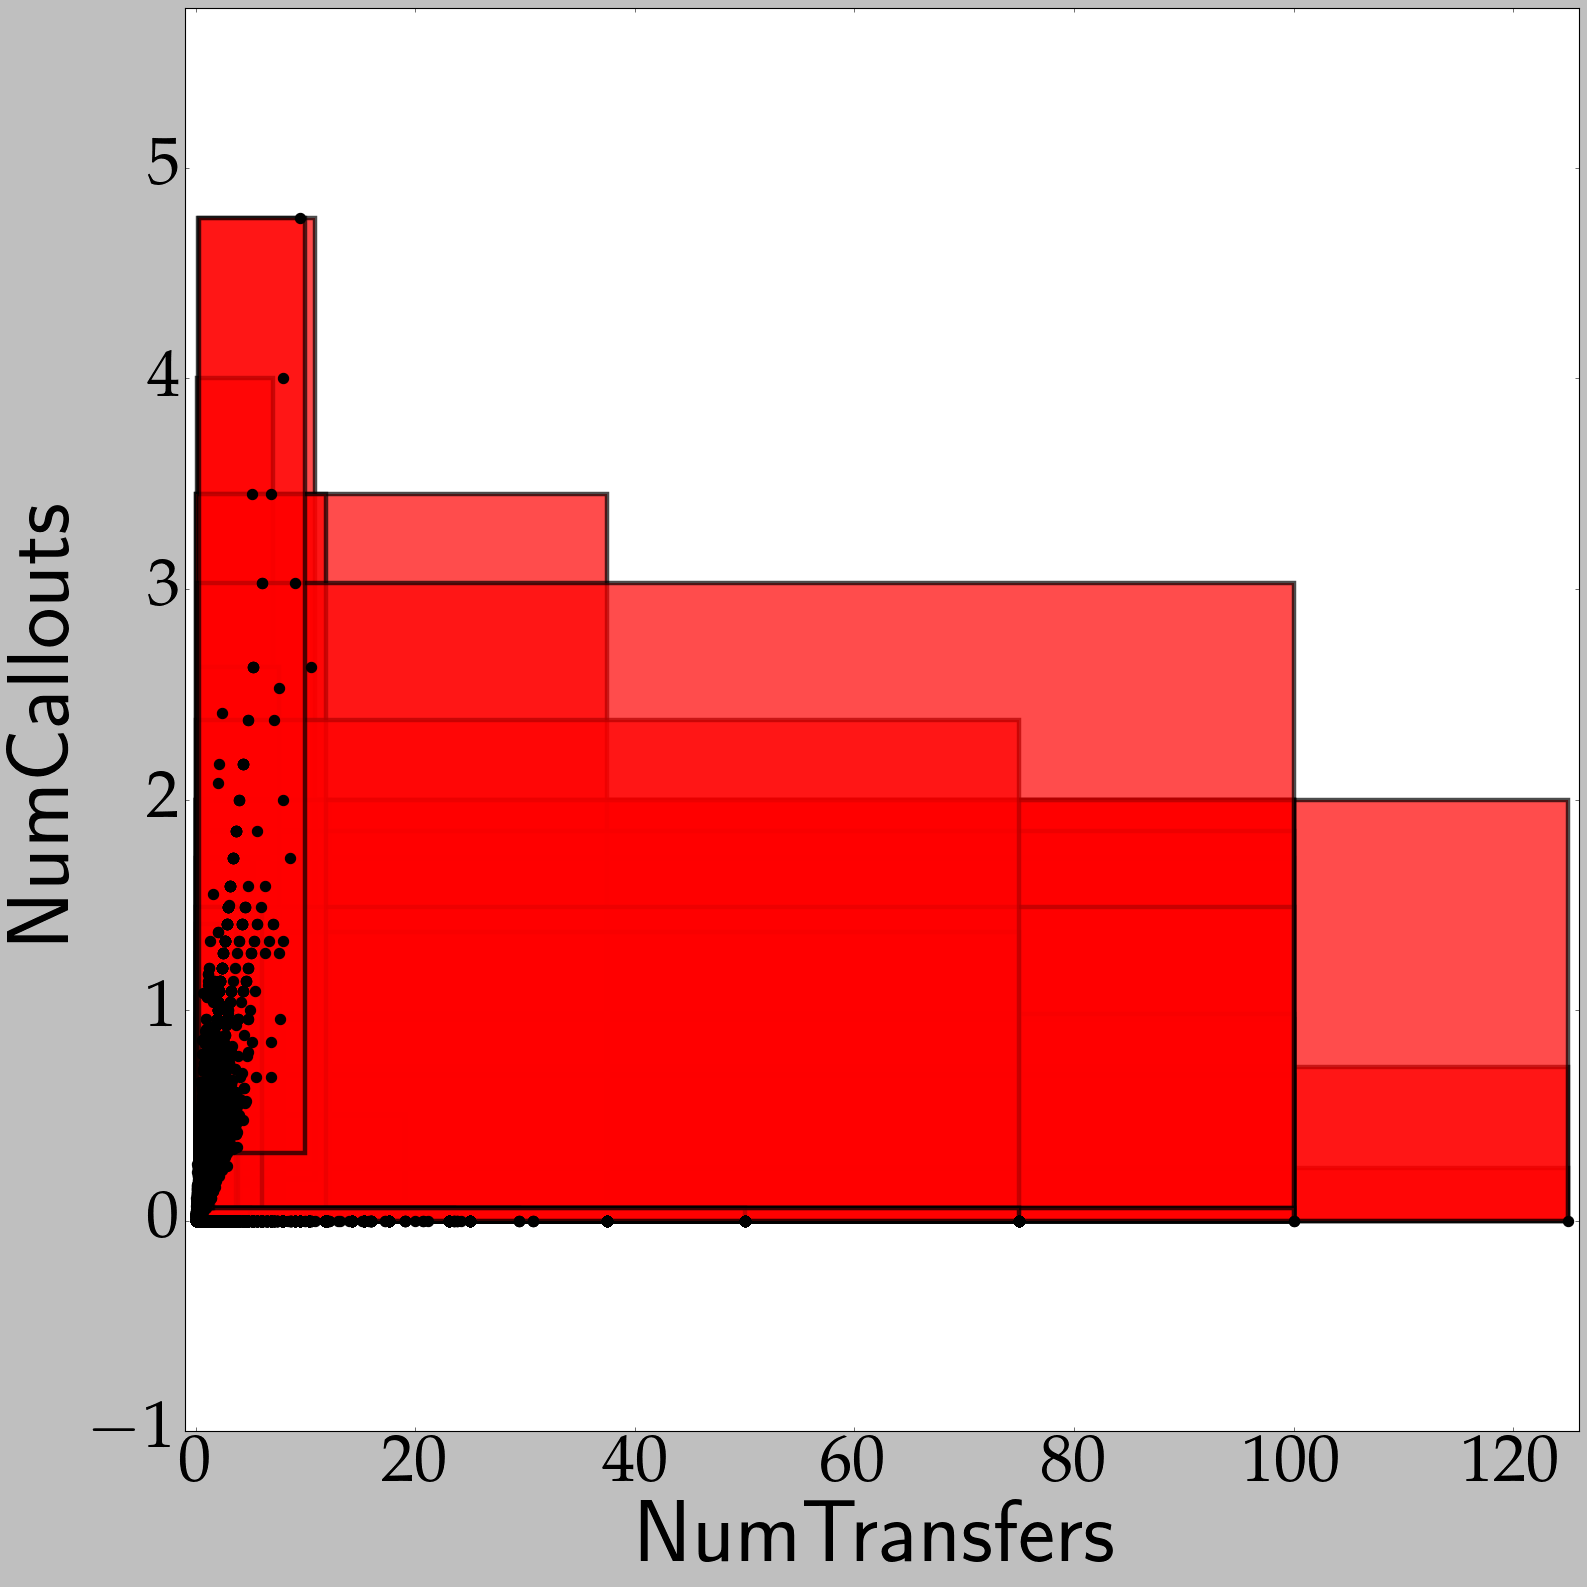

In [16]:
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
plt.scatter(df[column_x], df[column_y],color="k",s=85)
plt.savefig("plots/before_k_anonymity.pdf",
          bbox_inches="tight",
          dpi=300)

# Generating an k-Anonymous Dataset

Of course, to use the data we want to produce a new dataset that contains one row for each partition and value of the sensitive attribute. To do this, we need to aggregate the columns in each partition.  Let's do this!

In [17]:
def agg_categorical_column(series):
    return ','.join(set(series))

def agg_numerical_column(series):
    return series.mean()

In [18]:
def build_anonymized_dataset(df, partitions, 
                             feature_columns, 
                             sensitive_column,
                             categorical,
                             max_partitions=None):
#     aggregations = {}
#     for column in feature_columns:
#         if column in categorical:
#             aggregations[column] = agg_categorical_column
#         else:
#             aggregations[column] = agg_numerical_column
    cat_df = df[[col for col in df.columns if col in categorical]]
    num_df = df[[col for col in df.columns if col not in categorical]]
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        
#         grouped_columns = df.loc[partition]
#         print(type(grouped_columns))
#         grouped_columns = grouped_columns.agg(aggregations, 
#                                                 squeeze=False)
#         print(type(grouped_columns))
        grouped_columns = pd.concat([num_df.agg(agg_numerical_column), 
                                       cat_df.agg(agg_categorical_column)], axis=0)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count})
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [19]:
dfn = build_anonymized_dataset(df, 
                               finished_partitions, 
                               feature_columns, 
                               sensitive_column,
                              categorical)

Finished 1 partitions...


In [20]:
dfn.tail()

,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,NumOutput,...,ExpiredHospital,TotalNumInteract,gender,admit_type,admit_location,insurance,religion,ethnicity,LOSgroupNum,count
236,53.005884,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,...,0.099261,636.115579,"M,F","URGENT,ELECTIVE,NEWBORN,EMERGENCY","HMO REFERRAL/SICK,** INFO NOT AVAILABLE **,TRS...","Medicaid,Self Pay,Government,Medicare,Private","7TH DAY ADVENTIST,NOT SPECIFIED,JEHOVAH'S WITN...","HISPANIC/LATINO - MEXICAN,HISPANIC/LATINO - CU...",2,314
237,53.005884,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,...,0.099261,636.115579,"M,F","URGENT,ELECTIVE,NEWBORN,EMERGENCY","HMO REFERRAL/SICK,** INFO NOT AVAILABLE **,TRS...","Medicaid,Self Pay,Government,Medicare,Private","7TH DAY ADVENTIST,NOT SPECIFIED,JEHOVAH'S WITN...","HISPANIC/LATINO - MEXICAN,HISPANIC/LATINO - CU...",3,273
238,53.005884,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,...,0.099261,636.115579,"M,F","URGENT,ELECTIVE,NEWBORN,EMERGENCY","HMO REFERRAL/SICK,** INFO NOT AVAILABLE **,TRS...","Medicaid,Self Pay,Government,Medicare,Private","7TH DAY ADVENTIST,NOT SPECIFIED,JEHOVAH'S WITN...","HISPANIC/LATINO - MEXICAN,HISPANIC/LATINO - CU...",1,185
239,53.005884,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,...,0.099261,636.115579,"M,F","URGENT,ELECTIVE,NEWBORN,EMERGENCY","HMO REFERRAL/SICK,** INFO NOT AVAILABLE **,TRS...","Medicaid,Self Pay,Government,Medicare,Private","7TH DAY ADVENTIST,NOT SPECIFIED,JEHOVAH'S WITN...","HISPANIC/LATINO - MEXICAN,HISPANIC/LATINO - CU...",2,273
240,53.005884,0.099374,2.67596,0.785599,1.074118,30.379017,46.421124,1.219913,6.464789,7.111594,...,0.099261,636.115579,"M,F","URGENT,ELECTIVE,NEWBORN,EMERGENCY","HMO REFERRAL/SICK,** INFO NOT AVAILABLE **,TRS...","Medicaid,Self Pay,Government,Medicare,Private","7TH DAY ADVENTIST,NOT SPECIFIED,JEHOVAH'S WITN...","HISPANIC/LATINO - MEXICAN,HISPANIC/LATINO - CU...",3,323


In [21]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
# print("dfn.sort_values\n",
#       dfn.sort_values(feature_columns+[sensitive_column]))

# Implementing l-diversity (the naive way)

Now let's see how we can implement l-diversity in order to protect the privacy of the persons in the dataset even better. To implement l-diversity, we can do the following things:

* Modify our `is_valid` function to not only check for the size of a given partition but also ensure that the values of the sensitive attribute in the partition are diverse enough.
* Modify the `split` function to produce splits that are diverse (if possible)

**Implement a validator function that returns `True` if a given partition contains at least `l` different values of the sensitive attribute, `False` otherwise.**

In [22]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(df, partition, sensitive_column) >= l

In [23]:
# now let's apply this method to our data and see how the result changes
finished_l_diverse_partitions = partition_dataset(df, 
                                                  feature_columns, 
                                                  sensitive_column, 
                                                  full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [24]:
print("len(finished_l_diverse_partitions):",len(finished_l_diverse_partitions))

len(finished_l_diverse_partitions): 63


In [25]:
column_x, column_y = "NumTransfers", "NumCallouts"
l_diverse_rects = get_partition_rects(df, 
                                      finished_l_diverse_partitions, 
                                      column_x, column_y, 
                                      indexes, 
                                      offsets=[0.0, 0.0])

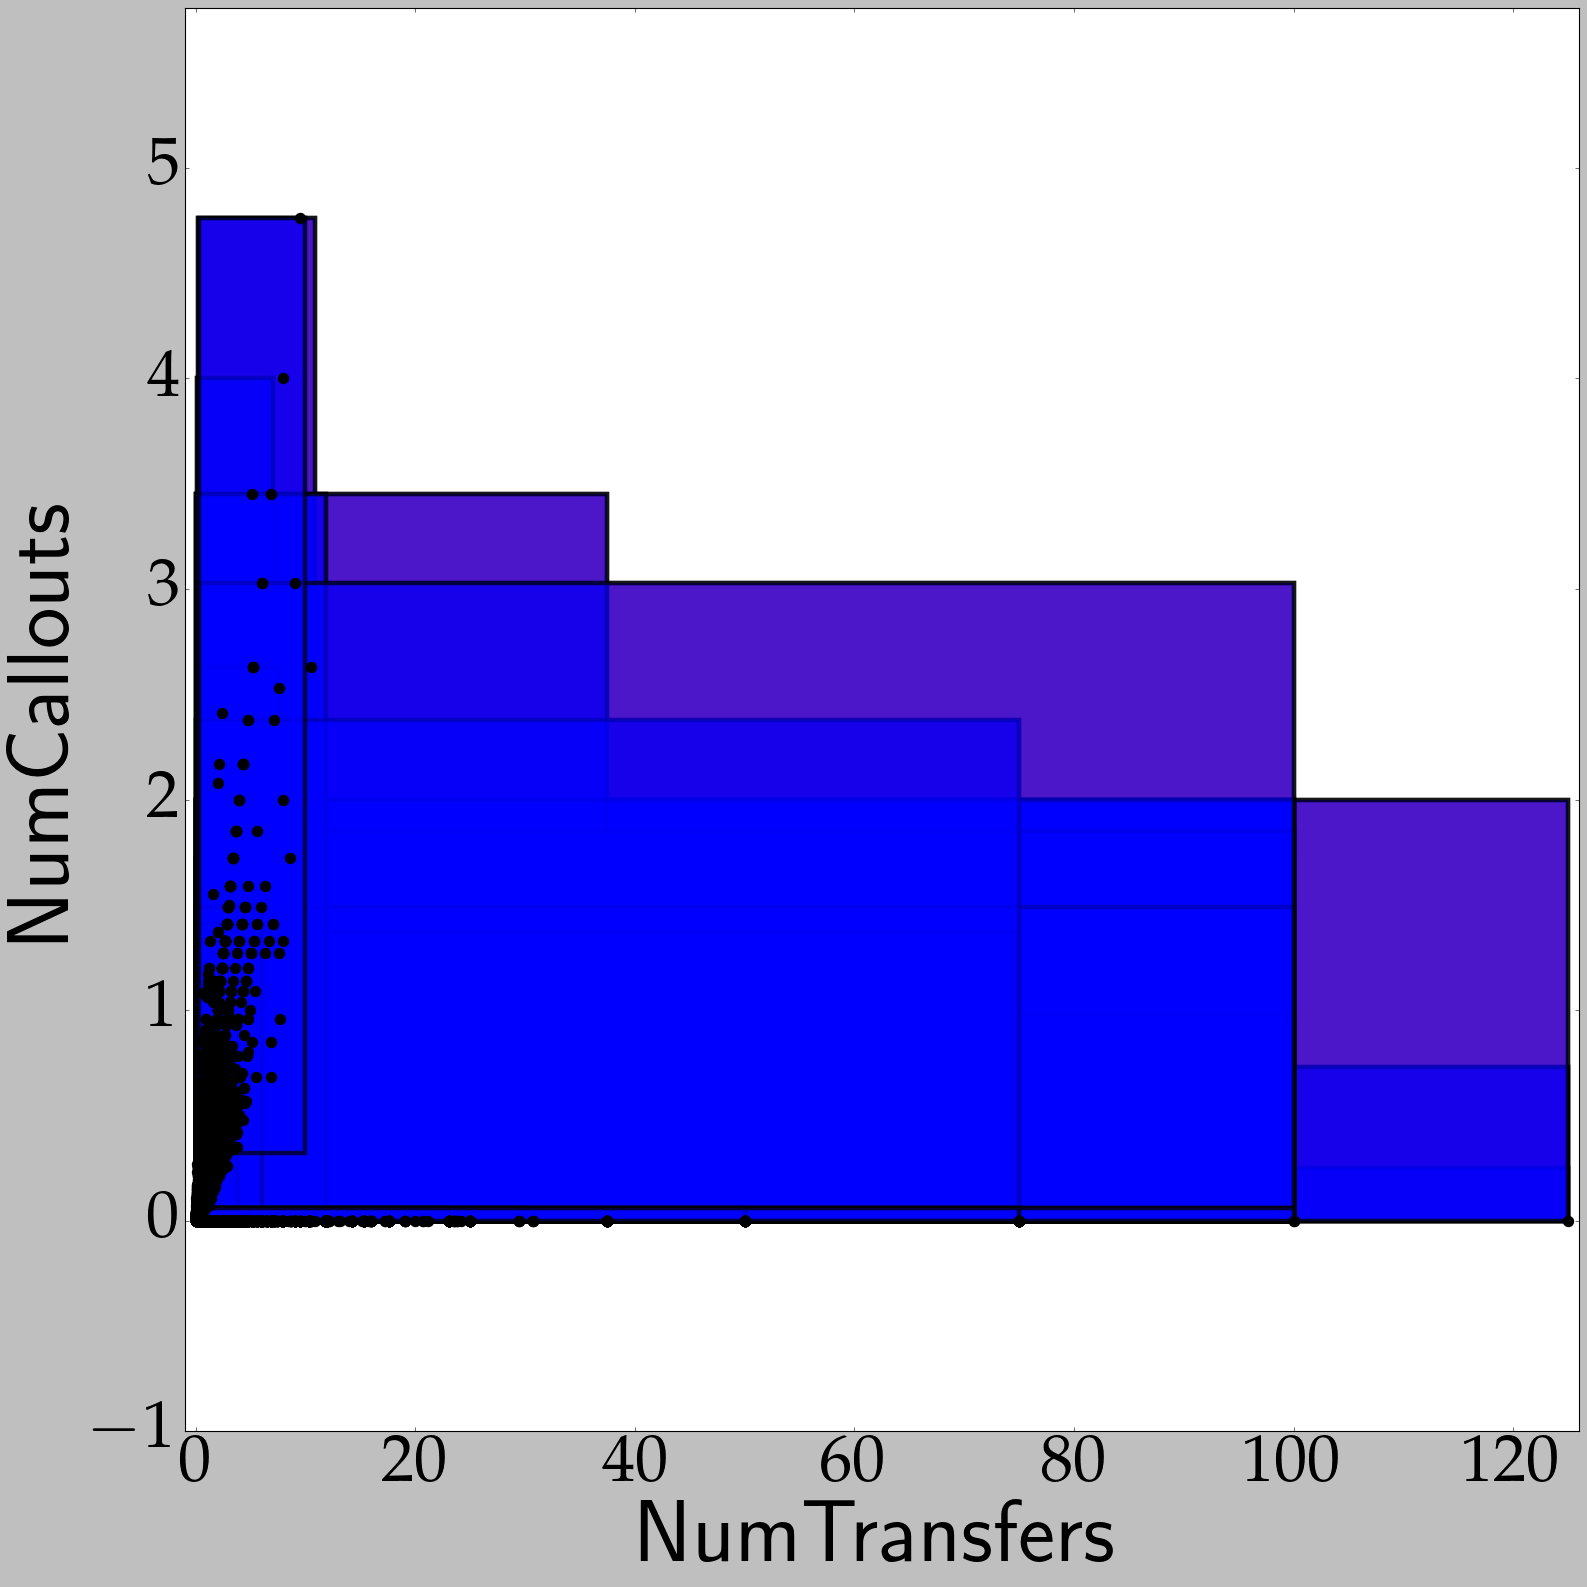

In [26]:
# plt.figure(figsize=(80,40))
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122)
# plot_rects(df, ax1, l_diverse_rects, column_x, column_y, edgecolor='k', facecolor='b')
# plot_rects(df, ax2, rects, column_x, column_y, facecolor='r')
# ax1.scatter(df[column_x], df[column_y])
# ax2.scatter(df[column_x], df[column_y])

plt.figure(figsize=(20,20))
ax = plt.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='k', facecolor='b')
ax.scatter(df[column_x], df[column_y],color='k',s=85)
plt.savefig("plots/after_l_diversity.pdf",
           bbox_inches="tight",
           dpi=300)

In [27]:
# again we build an anonymized dataset from the l-diverse partitions
dfl = build_anonymized_dataset(df, 
                               finished_l_diverse_partitions, 
                               feature_columns, 
                               sensitive_column,
                              categorical)

Finished 1 partitions...


In [28]:
# Let's see how l-diversity improves the anonymity of our dataset
# print("dfl.sort_values\n",
#       dfl.sort_values([column_x, column_y, sensitive_column]))

# Implementing t-closeness

As we can see, for regions where the value diversity is low, our l-diverse method produces partitions that contain a very large number of entries for one value of the sensitive attribute and only one entry for the other value. This is not ideal as while there is "plausible deniability" for a person in the dataset (after all the person could be the one "outlier") but an adversary can still be very certain about the person's attribute value in that case.

t-closeness solves this problem by making sure that the distribution of sensitive attribute values in a given partition is similar to the distribution of the values in the overall dataset.

**Implement a version of the `is_valid` function that returns `True` if the partition is diverse enough and `False` otherwise. To measure diversity, calculate the Kolmogorov-Smirnov distance between the empirical
probability distribution of the sensitive attribute over the entire dataset vs. the distribution over
the partition. Hint: the Kolmogorov-Smirnov distance is the maximum distance between the two distributions.
You can assume that the sensitive attribute is a categorical value.**

In [29]:
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [30]:
print("Global Frequencies for the sensitive column")
for k,v in global_freqs.items():
    print("val: {}, prob: {}".format(k,v))

Global Frequencies for the sensitive column
val: 0, prob: 0.2817756375474769
val: 1, prob: 0.31801071622354854
val: 2, prob: 0.1584034183396636
val: 3, prob: 0.24181022788931092


In [31]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [32]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, 
                                                feature_columns, 
                                                sensitive_column, 
                                                full_spans, 
                                                lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [33]:
print("len(finished_t_close_partitions):",len(finished_t_close_partitions))

len(finished_t_close_partitions): 56


In [34]:
dft = build_anonymized_dataset(df, 
                               finished_t_close_partitions, 
                               feature_columns, 
                               sensitive_column,
                              categorical)

Finished 1 partitions...


In [35]:
# Let's see how t-closeness fares
# print("dft.sort_values\n",
#       dft.sort_values([column_x, column_y, sensitive_column]))

In [36]:
column_x, column_y = "NumTransfers", "NumCallouts"
t_close_rects = get_partition_rects(df, 
                                    finished_t_close_partitions, 
                                    column_x, column_y, 
                                    indexes, offsets=[0.0, 0.0])

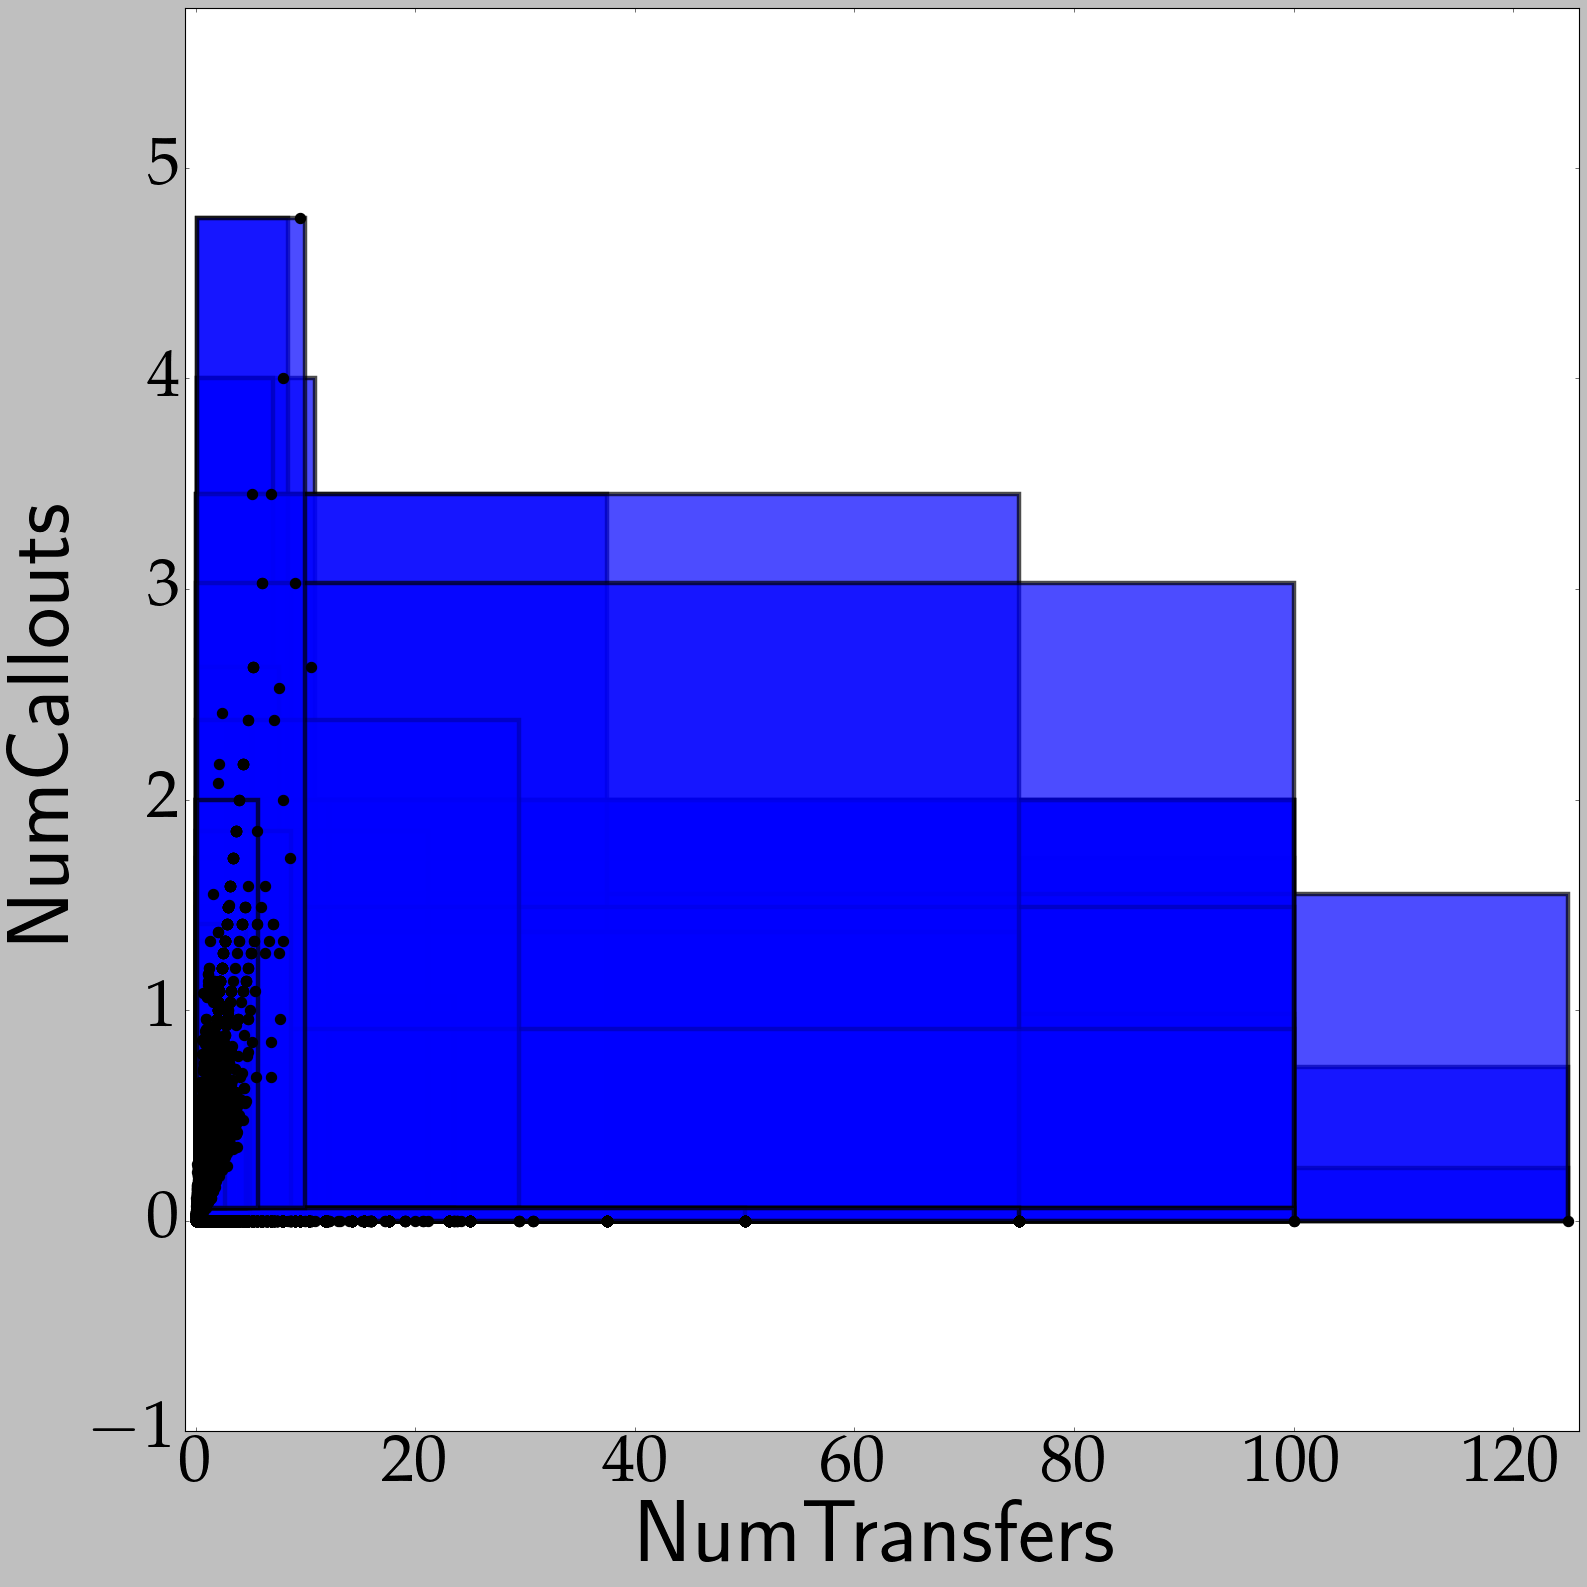

In [37]:
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='k', facecolor='b')
plt.scatter(df[column_x], df[column_y],color="k",s=85)
plt.savefig("plots/after_t_closeness.pdf",
           bbox_inches="tight",
           dpi=300)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

/home/akshaybaj/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/akshaybaj/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [39]:
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [40]:
random_state=11

svc = SVC(random_state=random_state)
clf = LogisticRegression(random_state=random_state)
rf = RandomForestClassifier(n_estimators=500,random_state=random_state)
xgb = XGBClassifier(random_state=random_state)

models = [svc, clf, rf, xgb]
model_names = ["Support Vector Classifier", 
              "Logistic Regression",
              "Random Forest Classifier",
               "XGBoost",]

sc = StandardScaler()

In [41]:
def convert_categorical(df,iscategory=True):
    if iscategory:
        cat_cols = [col for col in df.columns if df[col].dtype.name=="category" and col!="LOSgroupNum"]
    else:
        cat_cols = [col for col in df.columns if df[col].dtype=="object" and col!="LOSgroupNum"]
    #df_copy = df.copy(deep=True)
    for col in cat_cols:
        df = pd.concat([df,
                        pd.get_dummies(df[col], 
                                       prefix=col,
                                       dummy_na=True)],axis=1)
        df.drop([col],axis=1, inplace=True)
    return df

def train_and_test(df, predict_col, model, model_name, test_size=0.25):
    # print(df.columns)
    # print(df[predict_col])
    
    y = df[predict_col].astype('int')
    X=df.drop(predict_col,axis=1)
    #X=df
    X = sc.fit_transform(X)
    print("Standardization Done")
    x_train, x_test, y_train, y_test = train_test_split(X,
                                                       y,
                                                       test_size=test_size)
    print("Split done for train/val")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    acc = accuracy_score(y_pred, y_test)
    print("Model Name: {}, Accuracy: {:.3f}%".format(model_name,
                                               acc*100))
    print(confusion_matrix(y_pred, y_test))
    
    

In [42]:
# cat_cols = [col for col in df.columns if df[col].dtype.name=="category"]
# #df_copy = df.copy(deep=True)
# for col in cat_cols:
#     df = pd.concat([df,
#                     pd.get_dummies(df[col], 
#                                    prefix=col,
#                                    dummy_na=True)],axis=1)
#     df.drop([col],axis=1, inplace=True)

df_cat = convert_categorical(df)

In [43]:
### train_and_test(df_cat, "LOSgroupNum", models[0], model_names[0])
# for model, model_name in zip(models, model_names):
#     train_and_test(df_cat, "LOSgroupNum", model, model_name)
# train_and_test(df_cat, "LOSgroupNum", models[3], model_name[3])

In [44]:

# cat_cols = [col for col in dfn.columns if dfn[col].dtype=="object"]
# #print(dfn.dtypes)
# #df_copy = df.copy(deep=True)
# for col in cat_cols:
#     dfn = pd.concat([dfn,
#                     pd.get_dummies(dfn[col], 
#                                    prefix=col,
#                                    dummy_na=True)],axis=1)
#     dfn.drop([col],axis=1, inplace=True)
# dfn.head()

dfn_cat = convert_categorical(dfn,False)
for model, model_name in zip(models, model_names):
    train_and_test(dfn_cat, "LOSgroupNum", model, model_name)

Standardization Done
Split done for train/val
Model Name: Support Vector Classifier, Accuracy: 42.623%
[[ 2  0  1  1]
 [ 8 10  5  7]
 [ 4  4 12  5]
 [ 0  0  0  2]]
Standardization Done
Split done for train/val
Model Name: Logistic Regression, Accuracy: 22.951%
[[ 0  0  0  0]
 [11  3  4 12]
 [ 6  6 11  8]
 [ 0  0  0  0]]
Standardization Done
Split done for train/val
Model Name: Random Forest Classifier, Accuracy: 40.984%
[[ 3  4  2  5]
 [ 0 11  7  5]
 [ 4  2  5  1]
 [ 2  2  2  6]]
Standardization Done
Split done for train/val
Model Name: XGBoost, Accuracy: 39.344%
[[4 3 2 4]
 [2 6 2 3]
 [2 1 9 5]
 [2 4 7 5]]


In [45]:
# cat_cols = [col for col in dfl.columns if dfl[col].dtype=="object"]
# #print(dfn.dtypes)
# #df_copy = df.copy(deep=True)
# for col in cat_cols:
#     dfl = pd.concat([dfl,
#                     pd.get_dummies(dfl[col], 
#                                    prefix=col,
#                                    dummy_na=True)],axis=1)
#     dfl.drop([col],axis=1, inplace=True)
# dfl.head()

dfl_cat = convert_categorical(dfl,False)
for model, model_name in zip(models, model_names):
    train_and_test(dfl_cat, "LOSgroupNum", model, model_name)

Standardization Done
Split done for train/val
Model Name: Support Vector Classifier, Accuracy: 37.705%
[[ 1  0  1  1]
 [ 6 13  9  8]
 [ 5  1  9  7]
 [ 0  0  0  0]]
Standardization Done
Split done for train/val
Model Name: Logistic Regression, Accuracy: 32.787%
[[ 0  0  0  0]
 [ 6  8  1  5]
 [ 3  2  8  3]
 [ 6 10  5  4]]
Standardization Done
Split done for train/val
Model Name: Random Forest Classifier, Accuracy: 39.344%
[[3 4 1 4]
 [2 9 3 3]
 [4 0 9 4]
 [2 4 6 3]]
Standardization Done
Split done for train/val
Model Name: XGBoost, Accuracy: 44.262%
[[ 3  1  1  4]
 [ 3  8  2  6]
 [ 5  2 12  3]
 [ 1  4  2  4]]


In [46]:
# cat_cols = [col for col in dft.columns if dft[col].dtype=="object"]
# #print(dfn.dtypes)
# #df_copy = df.copy(deep=True)
# for col in cat_cols:
#     dft = pd.concat([dft,
#                     pd.get_dummies(dft[col], 
#                                    prefix=col,
#                                    dummy_na=True)],axis=1)
#     dft.drop([col],axis=1, inplace=True)
# dft.head()

dft_cat = convert_categorical(dft,False)
for model, model_name in zip(models, model_names):
    train_and_test(dft_cat, "LOSgroupNum", model, model_name)

Standardization Done
Split done for train/val
Model Name: Support Vector Classifier, Accuracy: 21.429%
[[0 3 1 0]
 [8 7 1 8]
 [8 3 4 7]
 [2 2 1 1]]
Standardization Done
Split done for train/val
Model Name: Logistic Regression, Accuracy: 30.357%
[[ 4  6  0  4]
 [ 0  1  0  2]
 [ 6  3 10  7]
 [ 4  6  1  2]]
Standardization Done
Split done for train/val
Model Name: Random Forest Classifier, Accuracy: 32.143%
[[5 5 2 6]
 [5 5 2 2]
 [1 2 5 3]
 [2 4 4 3]]
Standardization Done
Split done for train/val
Model Name: XGBoost, Accuracy: 35.714%
[[3 2 1 1]
 [2 6 3 1]
 [6 3 9 4]
 [5 5 3 2]]
